In [46]:
import pandas as pd
import tensorflow as tf
import numpy as np
import re 
import nltk
from nltk.corpus import stopwords
import itertools
from appostophes import appos 
from autocorrect import Speller


from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM, Bidirectional
from keras.layers import GlobalMaxPooling1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras import optimizers

from sklearn.preprocessing import LabelEncoder

In [12]:
import pandas as pd
# Read TRAINING data
train = pd.read_csv('/home/pankaj/Desktop/PROJECT/Datasets/pytree_sst/train2.txt', sep='\t', header=None, names=['truth', 'text'])
#train['truth'] = train['truth'].str.replace('__label__', '')
train['truth'] = train['truth'].astype(int).astype('category')
print("Number of sample in training set :", len(train))
train['truth'].value_counts()

Number of sample in training set : 6920


1    3610
0    3310
Name: truth, dtype: int64

In [13]:
import pandas as pd
# Read TRAINING data
test = pd.read_csv('/home/pankaj/Desktop/PROJECT/Datasets/pytree_sst/test2.txt', sep='\t', header=None, names=['truth', 'text'])
#test['truth'] = test['truth'].str.replace('__label__', '')
test['truth'] = test['truth'].astype(int).astype('category')

print("Number of sample in testing set :", len(test))
test['truth'].value_counts()

Number of sample in testing set : 1821


0    912
1    909
Name: truth, dtype: int64

In [14]:
import pandas as pd
# Read TRAINING data
dev = pd.read_csv('/home/pankaj/Desktop/PROJECT/Datasets/pytree_sst/dev2.txt', sep='\t', header=None, names=['truth', 'text'])
#dev['truth'] = dev['truth'].str.replace('__label__', '')
dev['truth'] = dev['truth'].astype(int).astype('category')

print("Number of sample in dev set :", len(dev))
dev['truth'].value_counts()

Number of sample in dev set : 872


1    444
0    428
Name: truth, dtype: int64

In [15]:
# DATA PRE-PROCESSING
def preprocess_text(sen):
    # 1. Removing HTML tags
    sentence = remove_tags(sen)
   # print(sentence)
    # 2. Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    #print(sentence) 
    # 3. Convert to lower case
    sentence= sentence.lower()
   # print(sentence)
    # 4. Apostrophes 
    sentence= remove_apostrophes(sentence)
    #print(sentence)
    # 5. Remove special characters
    sentence = remove_special_characters(sentence)
   # print(sentence)
    # 6. Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    #print(sentence)
    # 7. Standardise words
    #sentence= standardise1(sentence)
    #print(sentence)
    #8. spell check
   # sentence= spell_check(sentence)
    #print(sentence)

    return sentence

In [16]:
# 1. remove HTML tags 
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

In [17]:
# 4. Appostophes
def remove_apostrophes(text):
    #print(appos)
    words=text.split()  
    #print(words)
    reformed = [appos[word] if word in appos else word for word in words]
    reformed = " ".join(reformed)
    return reformed


In [18]:
 # 5. Remove special characters and digits
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z\s]'
    text=re.sub(pattern,' ',text)
    return text

In [19]:
# 7.1 Standardize words function-1
def standardise1(text):
    sent = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text))
    return sent

In [20]:
# 7.2 Standardize words function-2
def standardise2(text): 
    words=text.split()
    output_str= []
    for w in words:
        sc_removed = re.sub("[^a-zA-Z]", '', str(w))
        if len(sc_removed) > 1:
                output_str.append(sc_removed)
        joined = ' '.join(output_str)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [21]:
# spell check
spell = Speller(lang='en')
def spell_check(text):
    words=text.split()
    corrected=[]
    for w in words:
        corrected.append(spell(w))
    corrected=" ".join(str(x) for x in corrected)
    return corrected    

In [22]:
#spell = Speller(lang='en')
#spell("SOOO")
#preprocess_text("Helloooooo moble   007 can't  sooo  A #hapPy!!!")
preprocess_text("At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore.Its a low-budget film (thats never ")
#remove_special_characters("Hello 007 I'm happy!!!")

'at first it was very odd and pretty funny but as the movie progressed did not find the jokes or oddness funny anymore its low budget film  thats never'

In [23]:
# pre-process every statement and store it 
print("pre-processing starts")
train_reviews = []
p=0
sentences = list(train['text'])
for sen in sentences:
    train_reviews.append(preprocess_text(sen))
    p+=1

print("pre-processing over")    

pre-processing starts
pre-processing over


In [24]:
# pre-process every statement and store it 
print("pre-processing starts")
test_reviews = []
sentences = list(test['text'])
for sen in sentences:
    test_reviews.append(preprocess_text(sen))

print("pre-processing over")    

pre-processing starts
pre-processing over


In [25]:
# pre-process every statement and store it 
print("pre-processing starts")
dev_reviews = []
sentences = list(dev['text'])
for sen in sentences:
    dev_reviews.append(preprocess_text(sen))

print("pre-processing over")    

pre-processing starts
pre-processing over


In [26]:
train_label= train['truth']
test_label=test['truth']
dev_label=dev['truth']

In [27]:
len(train_reviews)

6920

In [28]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_reviews)

train_reviews = tokenizer.texts_to_sequences(train_reviews)
test_reviews = tokenizer.texts_to_sequences(test_reviews)
dev_reviews =tokenizer.texts_to_sequences(dev_reviews)

In [29]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
#print(type(X_train))
print("Number of training sample :",len(train_reviews))
print("Number of unique words :",vocab_size)
#print(X_train[0])
print((train_reviews[6]))

Number of training sample : 6920
Number of unique words : 13675
[254, 3, 1, 334, 3, 3679, 2461, 5, 7, 6, 2953, 1, 427, 11, 1447, 2, 4896]


In [30]:
maxlen = 50
print
train_reviews = pad_sequences(train_reviews, padding='post', maxlen=maxlen)
test_reviews  = pad_sequences(test_reviews, padding='post', maxlen=maxlen)
dev_reviews =pad_sequences(dev_reviews, padding='post', maxlen=maxlen)
print(type(train_reviews))
print(train_reviews.shape)

<class 'numpy.ndarray'>
(6920, 50)


In [31]:
print(type(train_reviews))
print(len(train_reviews))
print(train_reviews[6])
print(len(train_reviews[6]))

<class 'numpy.ndarray'>
6920
[ 254    3    1  334    3 3679 2461    5    7    6 2953    1  427   11
 1447    2 4896    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
50


In [32]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer

In [33]:
hole_embeddings_dictionary = dict()
glove_file = open('/home/pankaj/Desktop/PROJECT/Prebuild/content/wn30_holE_2e.tsv', encoding="utf8")
hole_vocab_size=0
for line in glove_file:  
    hole_vocab_size+=1
    records = line.split()   # sandberger 1 2 3 ... 100
    word = records[0]        # word = sandberger
    vector_dimensions = asarray(records[1:], dtype='float32')      # vector_dimensions = 1 2 ..100
    hole_embeddings_dictionary [word] = vector_dimensions               # add to dict word--> Embedding
glove_file.close()

print("Number of words :",hole_vocab_size)

Number of words : 264965


In [34]:
#============== WORD2VEC ===========================
import gensim
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('/home/pankaj/Desktop/PROJECT/Datasets/GoogleNews-vectors-negative300.bin', binary=True)

In [35]:
#w2v_model.wv['and'].shape

In [37]:
w2v_embeddings_dictionary = dict()
w2v_vocab_size=0

for idx, key in enumerate(w2v_model.wv.vocab):
    w2v_embeddings_dictionary[key] = w2v_model.wv[key]
    w2v_vocab_size+=1

print("NUmber of words in W@V :", w2v_vocab_size)

/home/pankaj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/home/pankaj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


NUmber of words in W@V : 3000000


In [38]:
#embeddings_dictionary.get('snowcapped_Caucasus')

In [39]:
embedding_matrix = zeros((vocab_size, 450))
w2v_absent=0
hole_absent=0
for word, index in tokenizer.word_index.items():
   # print(word)
    w2v_embedding_vector = w2v_embeddings_dictionary.get(word)
    hole_embedding_vector = hole_embeddings_dictionary.get(word)
    #if embedding_vector is not None:
     #   embedding_matrix[index] = embedding_vector
    
    if w2v_embedding_vector is  None:
        w2v_absent+=1
        #print(word)
        w2v_embedding_vector= np.random.uniform(0,1,300)
    if hole_embedding_vector is  None:
        hole_absent+=1
        hole_embedding_vector=np.random.uniform(0,1,150)
    
    embedding_matrix[index]= np.append(w2v_embedding_vector, hole_embedding_vector)

In [40]:
#print(records)

In [41]:
embedding_matrix[100:120][1:10]

array([[ 0.09619141, -0.02868652, -0.10839844, ..., -0.03790731,
         0.0150351 ,  0.08684701],
       [ 0.26953125,  0.0859375 ,  0.09423828, ...,  0.69689333,
         0.70179192,  0.96979282],
       [-0.07177734, -0.11035156,  0.00823975, ..., -0.01794351,
        -0.02599344, -0.08988973],
       ...,
       [ 0.36914062, -0.19238281,  0.10791016, ...,  0.08791675,
        -0.13086267, -0.10328002],
       [-0.03442383,  0.04174805,  0.24902344, ...,  0.77642061,
         0.83756501,  0.95123246],
       [-0.19433594, -0.06152344,  0.00915527, ..., -0.10659689,
        -0.05998106, -0.01441453]])

In [44]:
#====== SIMPLE NEURAL NETWORK===================
model = Sequential()
embedding_layer = Embedding(vocab_size, 450, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(2, activation='softmax'))

In [149]:
#======== CNN =================================
model = Sequential()
embedding_layer = Embedding(vocab_size, 450, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(5, activation='sigmoid'))

In [ ]:
#============== LSTM =================================
model = Sequential()
embedding_layer = Embedding(vocab_size, 450, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(LSTM(128))

model.add(Dense(5, activation='sigmoid'))

In [ ]:
#============== Bi-LSTM =================================

model = Sequential()
embedding_layer = Embedding(vocab_size, 450, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128)))
#model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(100, 1)))
#model.add(Bidirectional(LSTM(lstm_out = 128, dropout_U = 0.2, dropout_W = 0.2)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) 

In [ ]:
#==== LSTM WITH MULTIPLE LSTM-LAYERS ======
num_classes=1
model=Sequential()
#model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
embedding_layer = Embedding(vocab_size, 450, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='sigmoid'))

In [343]:
# ============== CNN-LSTM HYBRID APPROACH  ===============
model = Sequential()
embedding_layer = Embedding(vocab_size,450,weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128,5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(.7))


model.add(LSTM(128))
model.add(Dropout(.7))

model.add(Dense(5,activation='softmax'))

In [56]:
#from keras.utils import to_categorical
#train_label = to_categorical(train_label)
#train_label.shape
...
# encode class values as integers
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(train_label)
en_train_label = encoder.transform(train_label)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_train_label = np_utils.to_categorical(en_train_label)

encoder.fit(test_label)
en_test_label=encoder.transform(test_label)
dummy_test_label=np_utils.to_categorical(en_test_label)

encoder.fit(dev_label)
en_dev_label=encoder.transform(dev_label)
dummy_dev_label=np_utils.to_categorical(en_dev_label)


In [47]:
learning_rate=0.3
adam=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
#sgd = optimizers.SGD(learning_rate, decay=1e-6, momentum=0.9, nesterov=True)

In [48]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 450)           6153750   
_________________________________________________________________
flatten_1 (Flatten)          (None, 22500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 45002     
Total params: 6,198,752
Trainable params: 45,002
Non-trainable params: 6,153,750
_________________________________________________________________
None


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [49]:
history = model.fit(train_reviews, dummy_train_label, batch_size=128, validation_data=(dev_reviews,dummy_dev_label), epochs=2000, verbose=1, callbacks=[es])

NameError: name 'dummy_train_label' is not defined

In [59]:
score = model.evaluate(test_reviews, dummy_test_label, verbose=1)

1821/1821 [==============================] - 0s 42us/step


In [60]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print(history.history["loss"])

#print(history.history["val_acc"])

Test Score: 0.5255148267431746
Test Accuracy: 0.7419000547512228
[0.6668730303042196, 0.5813506161201896, 0.5266640984943147, 0.48689491497298887, 0.46300599823108296, 0.43761816493348576, 0.42335759311742177, 0.40538941587326843, 0.3893830984314053, 0.3750612305595696, 0.36513273939920987, 0.35426883897340367, 0.34468248066185525, 0.33654980914441146, 0.33150700930226057, 0.31773746682040266, 0.31496655651599686, 0.30689148482559736, 0.3034152742755206, 0.29245122264575407]


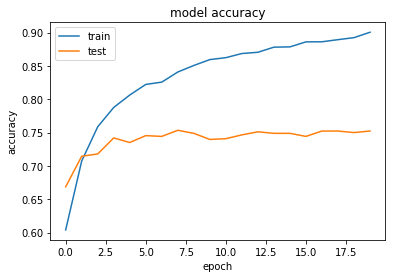

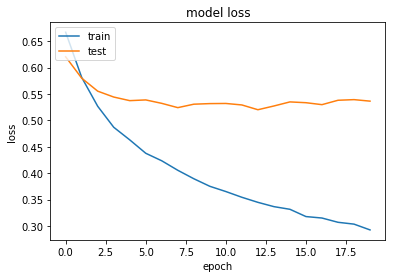

In [63]:
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
# plt.savefig('books_read.png')

In [62]:
# ==== PREDICT POLARITY OF SINGLE REVIEW ====
#instance= "The movie was awesome"
instance=train['text'][57]
print(instance)
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)



For devotees of French cinema , Safe Conduct is so rich with period minutiae it 's like dying and going to celluloid heaven .


In [395]:
model.predict(instance)

array([[0.590722  , 0.18129537, 0.04865884, 0.03547024, 0.14385352]],
      dtype=float32)